# Project Milestone 2 (P2)

## Context

In this project, we are going to analyze data from...


## The data

...

### Quotebank

...

### Wikidata

...

### Classifier

...


## Project proposal and initial analyses

 ...

## 1. Loading of the data and storing of vaccination dataframe

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
PATH = 'Data/'

### 1.1 Extracting only a sub data frame of interest

We are only interested by the quotes containing ... So to be quicker each time we load the data, we create a sub data frame containing only the quotes of interest. We save it as a pickle file.

## Function that we use

In [20]:
"""Create a sub data frame from df with quotations that contains the word (only one for now)"""
def extract_quotes(df, word):
    df_quotes = df[df['quotation'].str.contains(word)]
    return df_quotes


"""Transforming all the wikidata file in one dataset save as pickle to be able to load and use it easier and quicker"""
def saving_wikidata(path):
    wikidata_all = pd.DataFrame()
    PATH_PARQUET = 'Data_parquet/'
    for i in range(1,16):
        DATA_FILE = 'part-0000{}-0d587965-3d8f-41ce-9771-5b8c9024dce9-c000.snappy.parquet'.format(i)
        wikidata = pd.read_parquet(PATH_PARQUET + DATA_FILE)
        wikidata_all = pd.concat([wikidata_all, wikidata])
    wikidata_all.to_pickle(path)

"""Check if a target ('politician', 'male', 'female' etc...) is in a certain column.
If it is, we return True in an additional column (name_column) """
def add_columns(column, target, init_df, name_column):

    final_df = init_df.copy(deep = True)
    final_df[name_column] = final_df[column].apply(lambda x: np.any(x) in target)
    return final_df


"""Create a sub dataframe with information from quotebank and wikidata
We only take the rows in column which are True"""
def extracting_sub_df(quotebank, wikidata, column):
    merged_df = pd.merge(quotebank, wikidata, left_on= 'speaker', right_on='label')
    sub_df = merged_df[merged_df[column] == True]
    return sub_df


"""From all quotebank return a data frame with only the rows that respect the condition"""
def create_df_with_conditions(column, condition, wikidata, column_temp):
    wiki_plus = add_columns(column, condition, wikidata, column_temp)
    sub_df = pd.DataFrame()
    for i in range(20,21): #(15,21)
        DATA_FILE = 'quotes-20{}.json.bz2'.format(i)
        with pd.read_json(PATH + DATA_FILE, lines=True, compression='bz2', chunksize=100000) as df_reader:
            for chunk in df_reader:
                sub_df = pd.concat([sub_df, extracting_sub_df(chunk, wiki_plus, column_temp)])
    sub_df = sub_df.drop(column_temp, axis = 1)
    return sub_df



In [ ]:
""" Not to do each time, only once 
saving_wikidata("Data/parquet.pck")
"""

### 1.2 Loading information about the speaker

To be able to find information about the speaker, we use wikidata. The next cell was used to create a pickle of all the speaker.

In [2]:
wikidata_all = pd.read_pickle("Data/parquet.pck")
wikidata_all.shape

(8583613, 15)

Let's start by searching for redundant speaker.

In [3]:
wikidata_all['label'].is_unique

False

We can see that there are indeed duplicate rows. We'll now create a new dataframe (`cleaned_wikidata`) without this redundancy.

In [9]:

# Creation of a clean version of the data (without modifying the original one)
cleaned_wikidata = wikidata_all.copy(deep=True)

# Removal of duplicates of each id (the first is kept)
cleaned_wikidata = wikidata_all.drop_duplicates(subset=['label'], keep='first')

# Check for any duplicate ids
cleaned_wikidata['label'].is_unique


True

Let's now check if some rows have been removed

In [10]:
print(cleaned_wikidata.shape)


(6935018, 15)


We can see that 1,648,595 `label` have been removed

In [11]:
cleaned_wikidata.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,None,None,None,[Q6581097],985453603,None,None,None,None,None,Q45441526,Cui Yan,None,item,None
1,None,None,[Q9903],[Q6581097],1008699604,None,None,None,None,None,Q45441555,Guo Ziyi,None,item,None
2,None,None,[Q9903],[Q6581097],1008699709,None,None,None,None,None,Q45441562,Wan Zikui,None,item,None
3,None,None,[Q9903],[Q6581097],1008699728,None,None,None,None,None,Q45441563,Lin Pei,None,item,None
4,None,None,[Q9683],[Q6581097],985261661,None,None,None,None,None,Q45441565,Guan Zhen,None,item,None


Now we want to remove rows where import values are missing like the name of the speaker or his or her gender as we will focus only on speaker who identify as binary.

In [45]:
clean_copy = cleaned_wikidata.copy(deep=True)
clean_copy = clean_copy[~clean_copy.label.isin([None])]
print(clean_copy.shape)
clean_copy = clean_copy[~clean_copy.gender.isin([None])]
print(clean_copy.shape)



(6935017, 15)
(5351326, 15)


In [47]:
clean_copy['gender'] = clean_copy['gender'].apply(lambda x: x[0])

In [49]:
clean_copy['gender'].unique().shape

(31,)

We now made sure that we know every speaker name and gender and in the data.

In [44]:
clean_copy['gender'].unique()

array(['Q6581097', 'Q6581072', 'Q179294', 'Q1052281', 'Q48270',
       'Q2449503', 'Q18116794', 'Q12964198', 'Q15145779', 'Q189125',
       'Q859614', 'Q1097630', 'Q44148', 'Q1289754', 'Q301702',
       'Q106299064', 'Q27679684', 'Q15145778', 'Q52261234', 'Q207959',
       'Q505371', 'Q7130936', 'Q43445', 'Q96000630', 'Q27679766',
       'Q1984232', 'Q93954933', 'Q48279', 'Q3177577', 'Q1775415', 'Q6636'],
      dtype=object)

Doesn't the conflation between sex and gender into a single category ruin the entire point of wikidata?

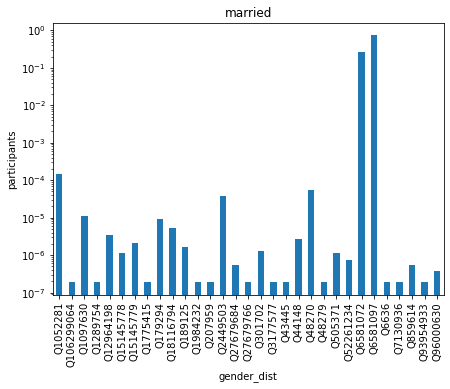

In [65]:
gender_dist = clean_copy.groupby('gender').size()
gender_dist = gender_dist.div(gender_dist.sum(axis=0), axis=0)
pl = gender_dist.plot(kind='bar', figsize=[7,5])
pl.set_title('married')
pl.set_ylabel('participants')
pl.set_xlabel('gender_dist')
pl.set_yscale('log')
plt.show()


Q 6581072 corresponds to female and Q 6581097 to male.

For our study we will keep only data corresponding to male and female.

### Create a data frame with all information

we now want to merge information of the speaker with our sub data frame

In [14]:
#Example for Politician
target = ['Q82955']
df_politician = create_df_with_conditions('occupation', target, cleaned_wikidata, 'ispolitician')
df_politician.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,aliases,...,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion,ispolitician
0,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,[Q367796],2020-01-16 12:00:13,1,"[[Sue Myrick, 0.8867], [None, 0.0992], [Ron Wy...",[http://thehill.com/opinion/international/4782...,E,None,...,M001134,[Q82955],[Q29468],None,Q367796,Sue Myrick,None,item,[Q329646],True
52,2020-01-20-000982,a host of other protections,Debbie Lesko,[Q16731415],2020-01-20 15:32:48,1,"[[Debbie Lesko, 0.4784], [None, 0.4105], [Ed M...",[https://www.cleveland.com/open/2020/01/the-eq...,E,None,...,L000589,[Q82955],[Q29468],None,Q16731415,Debbie Lesko,None,item,[Q5043],True
53,2020-01-09-060095,"No, are you kidding? The way that this place l...",Debbie Lesko,[Q16731415],2020-01-09 23:15:21,1,"[[Debbie Lesko, 0.7444], [None, 0.2323], [Pres...",[http://www.courthousenews.com/house-votes-to-...,E,None,...,L000589,[Q82955],[Q29468],None,Q16731415,Debbie Lesko,None,item,[Q5043],True
68,2020-04-11-000477,a manufacturer here in the state of California.,Gavin Newsom,[Q461391],2020-04-11 16:05:27,1,"[[Gavin Newsom, 0.7559], [None, 0.1312], [Rach...",[http://news.vice.com/en_us/article/qjdqnb/tru...,E,[Gavin Christopher Newsom],...,None,"[Q82955, Q3427922, Q43845]",[Q29552],None,Q461391,Gavin Newsom,None,item,[Q9592],True
69,2020-03-19-006948,"As you know, California has been disproportion...",Gavin Newsom,[Q461391],2020-03-19 22:50:00,7,"[[Gavin Newsom, 0.6593], [None, 0.263], [Presi...",[https://mynewsla.com/uncategorized/2020/03/19...,E,[Gavin Christopher Newsom],...,None,"[Q82955, Q3427922, Q43845]",[Q29552],None,Q461391,Gavin Newsom,None,item,[Q9592],True


In [21]:
#Example for Politician and Painter
target = ['Q82955', 'Q1028181']
df_politician = create_df_with_conditions('occupation', target, cleaned_wikidata, 'ispolitician')
df_politician.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,aliases,...,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion,ispolitician
0,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,[Q367796],2020-01-16 12:00:13,1,"[[Sue Myrick, 0.8867], [None, 0.0992], [Ron Wy...",[http://thehill.com/opinion/international/4782...,E,None,...,M001134,[Q82955],[Q29468],None,Q367796,Sue Myrick,None,item,[Q329646],True
52,2020-01-20-000982,a host of other protections,Debbie Lesko,[Q16731415],2020-01-20 15:32:48,1,"[[Debbie Lesko, 0.4784], [None, 0.4105], [Ed M...",[https://www.cleveland.com/open/2020/01/the-eq...,E,None,...,L000589,[Q82955],[Q29468],None,Q16731415,Debbie Lesko,None,item,[Q5043],True
53,2020-01-09-060095,"No, are you kidding? The way that this place l...",Debbie Lesko,[Q16731415],2020-01-09 23:15:21,1,"[[Debbie Lesko, 0.7444], [None, 0.2323], [Pres...",[http://www.courthousenews.com/house-votes-to-...,E,None,...,L000589,[Q82955],[Q29468],None,Q16731415,Debbie Lesko,None,item,[Q5043],True
68,2020-04-11-000477,a manufacturer here in the state of California.,Gavin Newsom,[Q461391],2020-04-11 16:05:27,1,"[[Gavin Newsom, 0.7559], [None, 0.1312], [Rach...",[http://news.vice.com/en_us/article/qjdqnb/tru...,E,[Gavin Christopher Newsom],...,None,"[Q82955, Q3427922, Q43845]",[Q29552],None,Q461391,Gavin Newsom,None,item,[Q9592],True
69,2020-03-19-006948,"As you know, California has been disproportion...",Gavin Newsom,[Q461391],2020-03-19 22:50:00,7,"[[Gavin Newsom, 0.6593], [None, 0.263], [Presi...",[https://mynewsla.com/uncategorized/2020/03/19...,E,[Gavin Christopher Newsom],...,None,"[Q82955, Q3427922, Q43845]",[Q29552],None,Q461391,Gavin Newsom,None,item,[Q9592],True


In [82]:
#politician_df.to_pickle("Data/politician.pck")

In [83]:
#politician_df.head()
politician_df = pd.read_pickle("Data/politician.pck")
politician_df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,aliases,...,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion,ispolitician
0,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,[Q367796],2020-01-16 12:00:13,1,"[[Sue Myrick, 0.8867], [None, 0.0992], [Ron Wy...",[http://thehill.com/opinion/international/4782...,E,None,...,M001134,[Q82955],[Q29468],None,Q367796,Sue Myrick,None,item,[Q329646],True
52,2020-01-20-000982,a host of other protections,Debbie Lesko,[Q16731415],2020-01-20 15:32:48,1,"[[Debbie Lesko, 0.4784], [None, 0.4105], [Ed M...",[https://www.cleveland.com/open/2020/01/the-eq...,E,None,...,L000589,[Q82955],[Q29468],None,Q16731415,Debbie Lesko,None,item,[Q5043],True
53,2020-01-09-060095,"No, are you kidding? The way that this place l...",Debbie Lesko,[Q16731415],2020-01-09 23:15:21,1,"[[Debbie Lesko, 0.7444], [None, 0.2323], [Pres...",[http://www.courthousenews.com/house-votes-to-...,E,None,...,L000589,[Q82955],[Q29468],None,Q16731415,Debbie Lesko,None,item,[Q5043],True
68,2020-04-11-000477,a manufacturer here in the state of California.,Gavin Newsom,[Q461391],2020-04-11 16:05:27,1,"[[Gavin Newsom, 0.7559], [None, 0.1312], [Rach...",[http://news.vice.com/en_us/article/qjdqnb/tru...,E,[Gavin Christopher Newsom],...,None,"[Q82955, Q3427922, Q43845]",[Q29552],None,Q461391,Gavin Newsom,None,item,[Q9592],True
69,2020-03-19-006948,"As you know, California has been disproportion...",Gavin Newsom,[Q461391],2020-03-19 22:50:00,7,"[[Gavin Newsom, 0.6593], [None, 0.263], [Presi...",[https://mynewsla.com/uncategorized/2020/03/19...,E,[Gavin Christopher Newsom],...,None,"[Q82955, Q3427922, Q43845]",[Q29552],None,Q461391,Gavin Newsom,None,item,[Q9592],True


### Saving data frame useful for processing

In [ ]:
"""vaccination_df.to_pickle("Data/2020_vaccin.pck")
wikidata_all.to_pickle("Data/parquet.pck")
merged_df.to_pickle("Data/merged_df.pck") """

## Processing

In [2]:
"""VACCINATION_DATASET = PATH+"2020_vaccin.pck"
vaccination = pd.read_pickle(VACCINATION_DATASET)
vaccination"""

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
317,2020-04-14-009511,comprehensive AIDS vaccine research initiative,President Clinton,[Q1124],2020-04-14 06:54:55,1,"[[President Clinton, 0.9128], [None, 0.0783], ...",[https://newswithviews.com/dr-fauci-and-dr-bir...,E
1550,2020-04-11-023226,"Some react fine to vaccines, others are paraly...",Mary Holland,"[Q28957276, Q6779784]",2020-04-11 08:25:08,3,"[[Mary Holland, 0.889], [None, 0.111]]",[https://www.freemalaysiatoday.com/category/wo...,E
2312,2020-03-02-074888,"Well, we've asked them to accelerate whatever ...",President Donald Trump,[Q22686],2020-03-02 17:19:01,1,"[[President Donald Trump, 0.6776], [None, 0.32...",[https://www.zawya.com/mena/en/multimedia/vide...,E
3596,2020-02-27-039401,"It is not a race between vaccine producers, it...",Paul Young,"[Q22101574, Q360501, Q3898174, Q46110256, Q518...",2020-02-27 21:53:39,1,"[[Paul Young, 0.9398], [None, 0.0602]]",[https://www.newshub.co.nz/home/world/2020/02/...,E
5597,2020-01-16-027502,I am only hopeful that when we start studying ...,None,[],2020-01-16 16:50:13,1,"[[None, 0.8717], [Melinda Gates, 0.1283]]",[http://www.medscape.com/viewarticle/923795?sr...,E
...,...,...,...,...,...,...,...,...,...
5242097,2020-03-11-009813,called for more public education about the vir...,Hillary Clinton,[Q6294],2020-03-11 15:28:51,2,"[[Hillary Clinton, 0.8098], [None, 0.1018], [D...",[http://www.politifact.com/factchecks/2020/mar...,E
5242130,2020-03-11-011441,"(COVID-19 is) different because, by definition...",Steve Woodard,[Q7614354],2020-03-11 19:53:44,1,"[[Steve Woodard, 0.7567], [None, 0.2433]]",[http://news4jax.com/news/local/2020/03/11/cit...,E
5242698,2020-04-12-012059,If we're going to have economic distress until...,Neel Kashkari,[Q1287635],2020-04-12 18:00:13,8,"[[Neel Kashkari, 0.8851], [None, 0.1149]]",[http://feeds.cbsnews.com/~r/CBSNewsMain/~3/hw...,E
5243373,2020-02-03-062993,Research continues on other approaches to a sa...,Anthony Fauci,[Q573246],2020-02-03 00:00:00,40,"[[Anthony Fauci, 0.8352], [None, 0.1195], [Lin...",[http://webwire.com/ViewPressRel.asp?aId=25435...,E


Loading the quotes and information about speaker

In [24]:
#merged_df = pd.read_pickle(PATH+"merged_df.pck")

In [25]:
#merged_df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,aliases,...,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,2020-04-11-023226,"Some react fine to vaccines, others are paraly...",Mary Holland,"[Q28957276, Q6779784]",2020-04-11 08:25:08,3,"[[Mary Holland, 0.889], [None, 0.111]]",[https://www.freemalaysiatoday.com/category/wo...,E,None,...,None,None,None,None,None,Q76284192,Mary Holland,None,item,None
1,2020-03-09-062055,They [ the manufacturers ] go to great lengths...,Mary Holland,"[Q28957276, Q6779784]",2020-03-09 15:40:00,1,"[[Mary Holland, 0.5209], [None, 0.4791]]",[https://canadafreepress.com/article/114247],E,None,...,None,None,None,None,None,Q76284192,Mary Holland,None,item,None
2,2020-01-03-005235,"As a legal matter vaccine are unavoidable, uns...",Mary Holland,"[Q28957276, Q6779784]",2020-01-03 03:12:51,1,"[[Mary Holland, 0.928], [None, 0.072]]",[http://newjersey.news12.com/story/41515094/ne...,E,None,...,None,None,None,None,None,Q76284192,Mary Holland,None,item,None
3,2020-04-11-023227,"Some react fine to vaccines, others are paraly...",Mary Holland,"[Q28957276, Q6779784]",2020-04-11 07:05:11,5,"[[Mary Holland, 0.8664], [None, 0.1336]]",[http://whbl.com/news/articles/2020/apr/11/cou...,E,None,...,None,None,None,None,None,Q76284192,Mary Holland,None,item,None
4,2020-04-11-009310,I don't think this virus fundamentally changes...,Mary Holland,"[Q28957276, Q6779784]",2020-04-11 07:05:11,8,"[[Mary Holland, 0.9035], [None, 0.0965]]",[http://whbl.com/news/articles/2020/apr/11/cou...,E,None,...,None,None,None,None,None,Q76284192,Mary Holland,None,item,None


# Brouillon de trucs qui peuvent être utils

Si on veut enregistrer dans un fichier txt les quotations pour le classifier 

In [3]:
quotes = vaccination.quotation.astype(str)
quotes.shape

(6538,)

In [4]:
text_file = open("MoodDiary.txt", "w")
#Opens or creates the .txt file, sharing the directory of the script#
for ind, quote in enumerate(quotes) : 
    print(quote)
    text_file.write(str(ind) + " " + quote + "\n")

#Writes the variable into the .txt file#
text_file.close()

comprehensive AIDS vaccine research initiative
Some react fine to vaccines, others are paralysed or killed.
Well, we've asked them to accelerate whatever they're doing, in terms of a vaccine, absolutely,
It is not a race between vaccine producers, it is a race against this particular virus,
I am only hopeful that when we start studying some of these new vaccines, pregnant women are included, not as part of phase 4 but earlier.
I think we all have never wanted science to work so quickly. But until there's either a vaccine, some sort of pharmaceutical intervention, or herd immunity, the science is the science.
This study is really important because it says that if you implement screening and vaccination programs right now in 2020, that improvements in screening coverage would have a bigger impact on prevention of invasive cancer and associated death,
Thousands fewer women will be diagnosed with cervical cancer as a result of improved screening services and the HPV vaccine and it's incred

UnicodeEncodeError: 'charmap' codec can't encode character '\x9f' in position 523: character maps to <undefined>

https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

## 2.Having Fun

## For the label of Qid

In [22]:
from wikidata.client import Client

entity = Client().get('Q6581097', load=True).label
print(entity)

male


In [21]:

entity = Client().get('Q82955', load=True)
print(entity.label)

politician


In [25]:
genre = Client().get(wikidata_all.gender,load=True)

TypeError: unhashable type: 'Series'